1. ดึงข้อมูล PTT (Limit: 300 วัน)...

2. เริ่มตรวจจับ Wyckoff Events ทั้งหมด...

✅ พบเหตุการณ์ Accumulation (SC/AR/Spring): 6 เหตุการณ์

3.1 แสดงกราฟ Wyckoff ACCUMULATION Events...


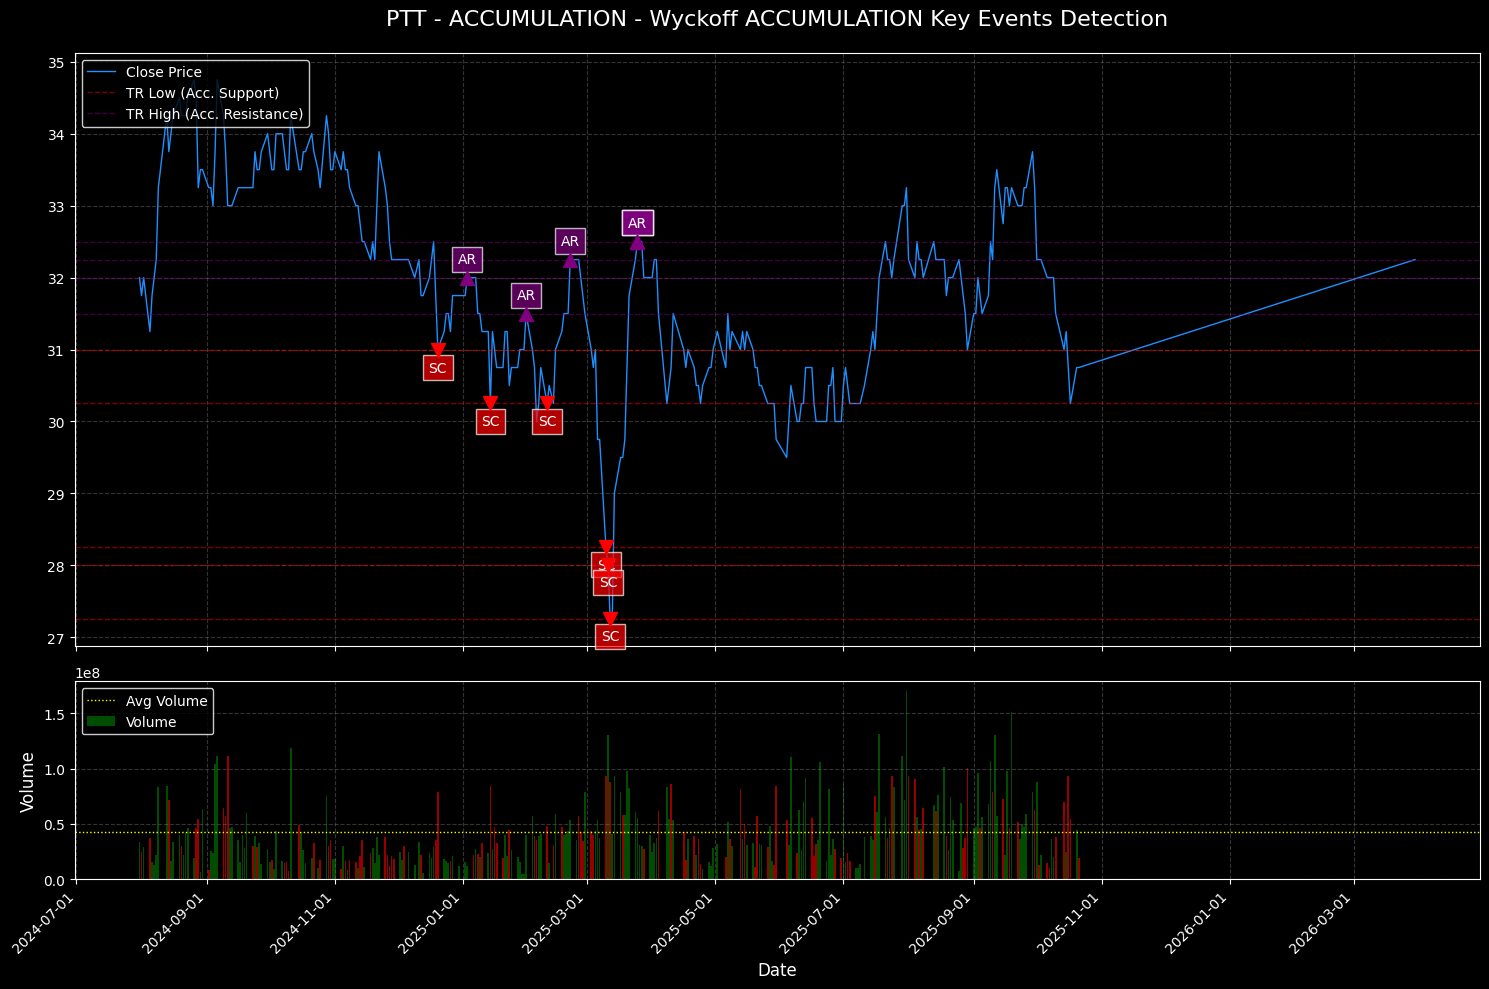


✅ พบเหตุการณ์ Distribution (BC/AR/UTAD): 4 เหตุการณ์

3.2 แสดงกราฟ Wyckoff DISTRIBUTION Events...


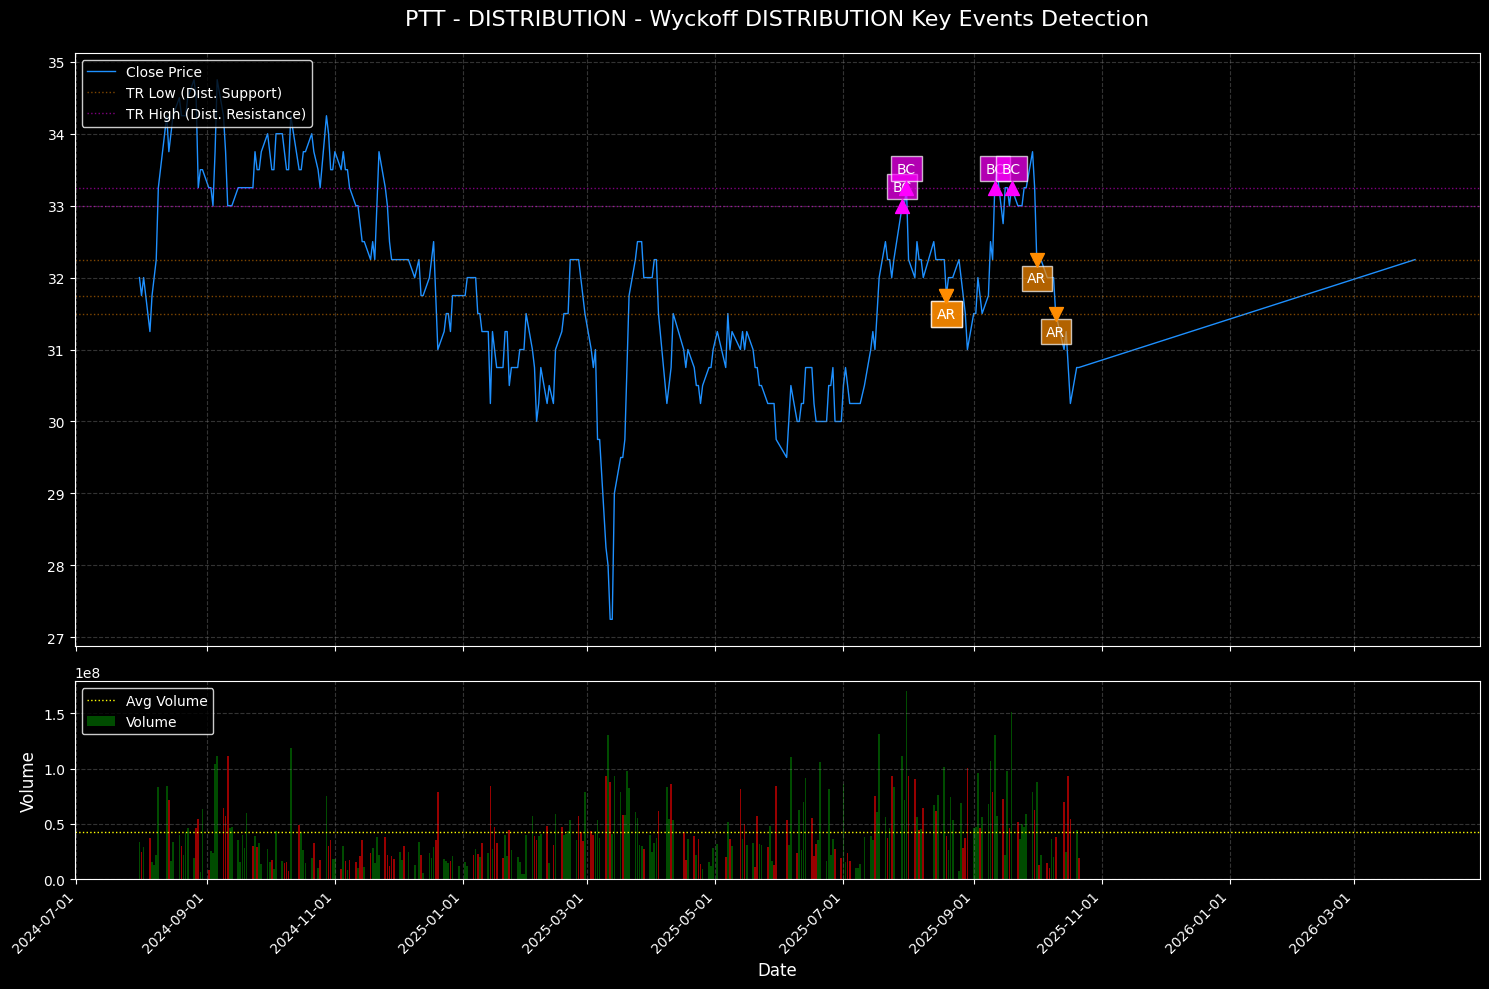

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from cassandra.cluster import Cluster

# กำหนดสไตล์การแสดงผลกราฟ
plt.style.use('dark_background')

# 1️⃣ ดึงข้อมูลจาก Cassandra
def get_candlestick_data(symbol: str, limit: int = 3000):
    """ดึงข้อมูลแท่งเทียนจาก Cassandra และจัดรูปแบบ"""
    try:
        # NOTE: ตรวจสอบให้แน่ใจว่า Cassandra Server รันอยู่ที่ 127.0.0.1:9042
        cluster = Cluster(['127.0.0.1'], port=9042)
        session = cluster.connect('stock_data')
    except Exception as e:
        print(f"Error connecting to Cassandra: {e}")
        raise ConnectionRefusedError("Could not connect to Cassandra. Check if it's running.")

    query = f"""
        SELECT time, open_price, high_price, low_price, close_price, volume
        FROM candlestick_data
        WHERE symbol='{symbol}'
        ORDER BY time DESC
        LIMIT {limit} 
    """
    rows = session.execute(query)
    df = pd.DataFrame(rows)

    if df.empty:
        raise ValueError(f"No data found for {symbol}")

    df.columns = df.columns.str.lower().str.strip()
    df.rename(columns={'open_price': 'open', 'high_price': 'high', 'low_price': 'low', 'close_price': 'close'}, inplace=True)
    df = df.sort_values('time')
    df.set_index('time', inplace=True)
    
    # แปลงข้อมูลเป็น float
    df[['open', 'high', 'low', 'close', 'volume']] = df[['open', 'high', 'low', 'close', 'volume']].astype(float)
    
    return df

    # 2.1 🔁 ตรวจจับ Wyckoff Distribution Key Events (สัญญาณขาย)
# ใช้ spring_tol เป็นตัวแปรกลางสำหรับค่าความคลาดเคลื่อน (Tolerance)
def detect_wyckoff_distribution(df, range_len=90, vol_factor=1.8, spring_tol=0.015, ar_check_len=15): 
    """
    ตรวจจับเหตุการณ์สำคัญใน Wyckoff Distribution Schematic (BC, AR, UTAD)
    """
    prices = df['close'].values
    volumes = df['volume'].values
    events = []
    
    avg_vol = df['volume'].rolling(window=range_len).mean()
    utad_tol = spring_tol # ใช้ชื่อ utad_tol ภายในเพื่อความหมายที่ชัดเจน
    
    for i in range(range_len, len(df)):
        current_prices = prices[i - range_len : i]
        current_volumes = volumes[i - range_len : i]
        
        # 1. 🔍 ตรวจจับ Buying Climax (BC)
        is_bc = (current_prices[-1] >= current_prices.max() * (1 - utad_tol)) and \
                (current_volumes[-1] > avg_vol.iloc[i] * vol_factor) and \
                (current_prices[-1] > current_prices[-5:].min()) 
        
        if is_bc:
            bc_idx = i - 1
            bc_price = prices[bc_idx]
            
            # 2. 🔍 ตรวจจับ Automatic Reaction (AR)
            ar_end_idx = min(i + ar_check_len, len(df))
            ar_range = prices[i:ar_end_idx]
            
            if len(ar_range) > 0:
                ar_idx_local = np.argmin(ar_range)
                ar_idx_global = i + ar_idx_local
                ar_price = prices[ar_idx_global]
                
                if (bc_price - ar_price) / bc_price > utad_tol * 2: 
                    events.append({
                        "type": "BC/AR",
                        "event_type": "Distribution",
                        "bc_idx": bc_idx,
                        "ar_idx": ar_idx_global,
                        "tr_high": bc_price,
                        "tr_low": ar_price
                    })

        # 3. 🔍 ตรวจจับ UTAD (Upthrust After Distribution)
        if len(events) > 0:
            last_event = events[-1]
            if last_event['type'] == 'BC/AR':
                tr_low = last_event['tr_low']
                tr_high = last_event['tr_high']
                
                # UTAD: ทะลุ TR High ชั่วคราว แล้วร่วงกลับเข้า TR
                if prices[i] > tr_high * (1 + utad_tol) and prices[i] > prices[i-1]:
                    vol_ratio = volumes[i] / avg_vol.iloc[i]
                    
                    if i + 1 < len(prices) and prices[i+1] < tr_high * (1 + utad_tol/2) and vol_ratio > 1.0:
                        events.append({
                            "type": "UTAD",
                            "event_type": "Distribution",
                            "tr_ref_idx": last_event['bc_idx'], 
                            "utad_idx": i,
                            "price": prices[i]
                        })
                        events.pop(-1) 

    final_events = [e for e in events if e['type'] == 'UTAD' or e['type'] == 'BC/AR']
    return final_events

# 2.2 🔽 ตรวจจับ Wyckoff Accumulation Key Events (สัญญาณซื้อ) - (โค้ดเดิม)
def detect_wyckoff_accumulation(df, range_len=90, vol_factor=1.8, spring_tol=0.015, ar_check_len=15):
    """ตรวจจับเหตุการณ์สำคัญใน Wyckoff Accumulation Schematic (SC, AR, Spring)"""
    prices = df['close'].values
    volumes = df['volume'].values
    events = []
    avg_vol = df['volume'].rolling(window=range_len).mean()
    
    for i in range(range_len, len(df)):
        current_prices = prices[i - range_len : i]
        current_volumes = volumes[i - range_len : i]
        
        # 1. 🔍 ตรวจจับ Selling Climax (SC)
        is_sc = (current_prices[-1] <= current_prices.min() * (1 + spring_tol)) and \
                (current_volumes[-1] > avg_vol.iloc[i] * vol_factor) and \
                (current_prices[-1] < current_prices[-5:].max()) 
        
        if is_sc:
            sc_idx = i - 1
            sc_price = prices[sc_idx]
            
            # 2. 🔍 ตรวจจับ Automatic Rally (AR)
            ar_end_idx = min(i + ar_check_len, len(df))
            ar_range = prices[i:ar_end_idx]
            
            if len(ar_range) > 0:
                ar_idx_local = np.argmax(ar_range)
                ar_idx_global = i + ar_idx_local
                ar_price = prices[ar_idx_global]
                
                if (ar_price - sc_price) / sc_price > spring_tol * 2: 
                    events.append({
                        "type": "SC/AR",
                        "event_type": "Accumulation",
                        "sc_idx": sc_idx,
                        "ar_idx": ar_idx_global,
                        "tr_low": sc_price,
                        "tr_high": ar_price
                    })

        # 3. 🔍 ตรวจจับ Spring/Shakeout
        if len(events) > 0:
            last_event = events[-1]
            if last_event['type'] == 'SC/AR':
                tr_low = last_event['tr_low']
                tr_high = last_event['tr_high']
                
                # Spring: หลุด TR Low ชั่วคราว แล้วดีดกลับเข้า TR
                if prices[i] < tr_low * (1 - spring_tol) and prices[i] < prices[i-1]:
                    vol_ratio = volumes[i] / avg_vol.iloc[i]
                    
                    if i + 1 < len(prices) and prices[i+1] > tr_low * (1 - spring_tol/2) and vol_ratio > 1.0:
                        events.append({
                            "type": "Spring",
                            "event_type": "Accumulation",
                            "tr_ref_idx": last_event['sc_idx'], 
                            "spring_idx": i,
                            "price": prices[i]
                        })
                        events.pop(-1) 

    final_events = [e for e in events if e['type'] == 'Spring' or e['type'] == 'SC/AR']
    return final_events

# 2.3 🤝 ฟังก์ชันหลักในการตรวจจับทั้งหมด
def detect_all_wyckoff_events(df, **kwargs):
    """รันการตรวจจับทั้ง Accumulation และ Distribution แล้วรวมผล"""
    acc_events = detect_wyckoff_accumulation(df, **kwargs)
    dist_events = detect_wyckoff_distribution(df, **kwargs)
    return acc_events + dist_events

 # 3️⃣ Plot Wyckoff Accumulation & Distribution Events (ปรับปรุง Title)
def plot_wyckoff_events(df, all_wyckoff_events, symbol='SYMBOL'):
    """วาดกราฟราคาและวอลุ่ม พร้อมแสดงเหตุการณ์ Wyckoff (Accumulation และ Distribution)"""
    if not all_wyckoff_events:
        # หากไม่มีเหตุการณ์เลย ก็ยังแสดงกราฟเปล่าได้ แต่ตั้งชื่อตาม symbol ที่รับมา
        plot_title = f"{symbol} - No Wyckoff Events Detected"
    else:
        # 🆕 ตรวจสอบประเภทของเหตุการณ์ที่ถูกกรองมาเพื่อตั้งชื่อ Title
        event_types = {e.get('event_type') for e in all_wyckoff_events}
        
        if len(event_types) == 1:
            # หากมีแค่ Accumulation หรือ Distribution อย่างใดอย่างหนึ่ง
            chart_type = event_types.pop().upper() 
            plot_title = f"{symbol} - Wyckoff {chart_type} Key Events Detection"
        elif len(event_types) > 1:
            # หากมีทั้งสองประเภท (หรือมีมากกว่าหนึ่ง)
            plot_title = f"{symbol} - Wyckoff Accumulation & Distribution Key Events Detection"
        else:
            # กรณีที่มี events แต่ event_type เป็น None (ไม่ควรเกิดขึ้น)
            plot_title = f"{symbol} - Wyckoff Key Events Detection (Mixed/Unknown)"


    # สร้างกราฟ 2 ส่วน (ราคากับวอลุ่ม)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True, 
                                   gridspec_kw={'height_ratios': [3, 1]})
    dates = df.index
    prices = df['close'].values
    volumes = df['volume'].values

    # 1. Plot ราคา (ax1)
    ax1.plot(dates, prices, color='dodgerblue', linewidth=1, label='Close Price', zorder=1)
    
    # 2. Plot วอลุ่ม (ax2)
    volume_colors = ['green' if df['close'].iloc[i] >= df['open'].iloc[i] else 'red' for i in range(len(df))]
    ax2.bar(dates, volumes, color=volume_colors, alpha=0.6, label='Volume')
    ax2.axhline(df['volume'].mean(), color='yellow', linestyle=':', linewidth=1, label='Avg Volume')

    # 3. Mark Key Events and Trading Range
    tr_lines_drawn = set() 
    
    all_wyckoff_events.sort(key=lambda x: x.get('sc_idx') or x.get('bc_idx') or x.get('spring_idx') or x.get('utad_idx'))
    
    for event in all_wyckoff_events:
        event_type = event.get('event_type')
        
        if event_type == 'Accumulation':
            # --- ACCUMULATION EVENTS (สีโทนเขียว/ม่วง) ---
            if event['type'] == 'SC/AR':
                sc_idx, ar_idx = event['sc_idx'], event['ar_idx']
                
                # Mark SC
                ax1.scatter(dates[sc_idx], prices[sc_idx], color='red', s=100, marker='v', zorder=5)
                ax1.annotate("SC", (dates[sc_idx], prices[sc_idx] * 0.995), color='white', fontsize=10, ha='center', va='top', bbox=dict(facecolor='red', alpha=0.7))
                # Mark AR
                ax1.scatter(dates[ar_idx], prices[ar_idx], color='purple', s=100, marker='^', zorder=5)
                ax1.annotate("AR", (dates[ar_idx], prices[ar_idx] * 1.005), color='white', fontsize=10, ha='center', va='bottom', bbox=dict(facecolor='purple', alpha=0.7))
                
                # Draw TR Lines 
                if (event['tr_low'], 'Acc') not in tr_lines_drawn:
                    ax1.axhline(event['tr_low'], color='red', linestyle='--', linewidth=1, alpha=0.5, label='TR Low (Acc. Support)')
                    tr_lines_drawn.add((event['tr_low'], 'Acc'))
                if (event['tr_high'], 'Acc') not in tr_lines_drawn:
                    ax1.axhline(event['tr_high'], color='purple', linestyle='--', linewidth=1, alpha=0.5, label='TR High (Acc. Resistance)')
                    tr_lines_drawn.add((event['tr_high'], 'Acc'))
                
            elif event['type'] == 'Spring':
                idx = event['spring_idx']
                # Mark Spring
                ax1.scatter(dates[idx], prices[idx], color='lime', s=150, marker='*', edgecolors='black', linewidth=1.5, zorder=6)
                ax1.annotate("SPRING (Buy)", (dates[idx], prices[idx] * 0.99), color='black', fontsize=12, fontweight='bold', ha='center', va='top', bbox=dict(facecolor='lime', alpha=0.9))
                ax2.scatter(dates[idx], volumes[idx], color='lime', s=80, zorder=6)


        elif event_type == 'Distribution':
            # --- DISTRIBUTION EVENTS (สีโทนชมพู/ส้ม/แดง) ---
            if event['type'] == 'BC/AR':
                bc_idx, ar_idx = event['bc_idx'], event['ar_idx']
                
                # Mark BC
                ax1.scatter(dates[bc_idx], prices[bc_idx], color='fuchsia', s=100, marker='^', zorder=5)
                ax1.annotate("BC", (dates[bc_idx], prices[bc_idx] * 1.005), color='white', fontsize=10, ha='center', va='bottom', bbox=dict(facecolor='fuchsia', alpha=0.7))
                # Mark AR (Reaction)
                ax1.scatter(dates[ar_idx], prices[ar_idx], color='darkorange', s=100, marker='v', zorder=5)
                ax1.annotate("AR", (dates[ar_idx], prices[ar_idx] * 0.995), color='white', fontsize=10, ha='center', va='top', bbox=dict(facecolor='darkorange', alpha=0.7))
                
                # Draw TR Lines 
                if (event['tr_low'], 'Dist') not in tr_lines_drawn:
                    ax1.axhline(event['tr_low'], color='darkorange', linestyle=':', linewidth=1, alpha=0.5, label='TR Low (Dist. Support)')
                    tr_lines_drawn.add((event['tr_low'], 'Dist'))
                if (event['tr_high'], 'Dist') not in tr_lines_drawn:
                    ax1.axhline(event['tr_high'], color='fuchsia', linestyle=':', linewidth=1, alpha=0.5, label='TR High (Dist. Resistance)')
                    tr_lines_drawn.add((event['tr_high'], 'Dist'))

            elif event['type'] == 'UTAD':
                idx = event['utad_idx']
                # Mark UTAD
                ax1.scatter(dates[idx], prices[idx], color='red', s=150, marker='X', edgecolors='black', linewidth=1.5, zorder=6)
                ax1.annotate("UTAD (Sell)", (dates[idx], prices[idx] * 1.005), color='white', fontsize=12, fontweight='bold', ha='center', va='bottom', bbox=dict(facecolor='red', alpha=0.9))
                ax2.scatter(dates[idx], volumes[idx], color='red', s=80, zorder=6)


    # --- ปรับแต่งกราฟ ---
    # 🆕 ใช้ plot_title ที่คำนวณไว้ด้านบน
    ax1.set_title(plot_title, color='white', fontsize=16, pad=20) 
    ax1.tick_params(axis='y', colors='white')
    ax1.grid(True, color='gray', linestyle='--', alpha=0.4)
    
    handles, labels = ax1.get_legend_handles_labels()
    unique_labels = dict(zip(labels, handles))
    ax1.legend(unique_labels.values(), unique_labels.keys(), facecolor='black', edgecolor='white', loc='upper left')

    ax2.set_xlabel("Date", color='white', fontsize=12)
    ax2.set_ylabel("Volume", color='white', fontsize=12)
    ax2.tick_params(axis='x', colors='white')
    ax2.tick_params(axis='y', colors='white')
    ax2.grid(True, color='gray', linestyle='--', alpha=0.4)
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.xticks(rotation=45, ha='right')
    
    handles2, labels2 = ax2.get_legend_handles_labels()
    unique_labels2 = dict(zip(labels2, handles2))
    ax2.legend(unique_labels2.values(), unique_labels2.keys(), facecolor='black', edgecolor='white', loc='upper left')

    plt.tight_layout()
    plt.show()

    # 4️⃣ ตัวอย่างการใช้งาน (Execution)
try:
    # --- Config ---
    symbol = "PTT"  # หรือหุ้นที่คุณต้องการวิเคราะห์
    DATA_LIMIT = 300 
    
    print(f"1. ดึงข้อมูล {symbol} (Limit: {DATA_LIMIT} วัน)...")
    df_original = get_candlestick_data(symbol, limit=DATA_LIMIT)
    
    # 2. ตรวจจับ Wyckoff Events ทั้งหมด (Accumulation & Distribution)
    print("\n2. เริ่มตรวจจับ Wyckoff Events ทั้งหมด...")
    all_wyckoff_events = detect_all_wyckoff_events(
        df_original, 
        range_len=90, 
        vol_factor=1.8, 
        spring_tol=0.015
    )
    
    # --- 🆕 การแยกและแสดงผล Accumulation Events ---
    acc_events = [e for e in all_wyckoff_events if e.get('event_type') == 'Accumulation']
    acc_count = len(acc_events)
    print(f"\n✅ พบเหตุการณ์ Accumulation (SC/AR/Spring): {acc_count} เหตุการณ์")
    print("\n3.1 แสดงกราฟ Wyckoff ACCUMULATION Events...")
    plot_wyckoff_events(df_original, acc_events, symbol=f"{symbol} - ACCUMULATION")
    
    # --- 🆕 การแยกและแสดงผล Distribution Events ---
    dist_events = [e for e in all_wyckoff_events if e.get('event_type') == 'Distribution']
    dist_count = len(dist_events)
    print(f"\n✅ พบเหตุการณ์ Distribution (BC/AR/UTAD): {dist_count} เหตุการณ์")
    print("\n3.2 แสดงกราฟ Wyckoff DISTRIBUTION Events...")
    plot_wyckoff_events(df_original, dist_events, symbol=f"{symbol} - DISTRIBUTION")
    
    
except ConnectionRefusedError as e:
    print(f"\n❌ การเชื่อมต่อล้มเหลว: {e}")
    print("โปรดตรวจสอบว่า Cassandra Server (127.0.0.1:9042) ได้รันอยู่หรือไม่")
except ValueError as e:
    print(f"\n❌ ข้อผิดพลาดข้อมูล: {e}")
except Exception as e:
    print(f"\n❌ เกิดข้อผิดพลาดที่ไม่คาดคิด: {e}")
    print(f"Detail: {e}")